In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
data = pd.read_csv('bank-full.csv', delimiter=';')

# Check for any missing values and fill if necessary using forward fill
data.ffill(inplace=True)

# Select categorical columns for one-hot encoding
categorical_cols = [cname for cname in data.columns if data[cname].dtype == "object" and cname != 'y']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ], remainder='passthrough')

# Apply preprocessing pipeline
X = data.drop('y', axis=1)
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and apply the preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

print("Data preprocessing complete.")


Data preprocessing complete.


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the model with an alternative solver and include feature scaling
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=5000, solver='saga', random_state=42))
])

# Create a cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define different scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# Evaluate the model using cross-validation
cv_results = cross_val_score(log_reg_pipeline, X_train_prepared, y_train, cv=cv_strategy, scoring='roc_auc')

# Print the results
print("Cross-validated ROC AUC scores:", cv_results)
print("Mean ROC AUC score:", cv_results.mean())

# Further detailed scoring
detailed_scores = {}
for metric_name, scorer in scoring_metrics.items():
    scores = cross_val_score(log_reg_pipeline, X_train_prepared, y_train, cv=cv_strategy, scoring=scorer)
    detailed_scores[metric_name] = scores
    print(f"Mean {metric_name}: {scores.mean()} ± {scores.std()}")

# Fit the model to the training data
log_reg_pipeline.fit(X_train_prepared, y_train)


Cross-validated ROC AUC scores: [0.91302486 0.89943567 0.90469153 0.9045194  0.9128375 ]
Mean ROC AUC score: 0.9069017896233136
Mean accuracy: 0.9022894253945672 ± 0.0020553757120199555
Mean precision: 0.6499998722551081 ± 0.01858132300404023
Mean recall: 0.34326323854929336 ± 0.008876448392747002
Mean f1: 0.44918732874393197 ± 0.010429587092911329
Mean roc_auc: 0.9069017896233136 ± 0.005273113490088282


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=5000, random_state=42,
                                    solver='saga'))])

Optimal Threshold: 0.17229892083570253
Optimal F1 Score: 0.5854922279792746
Precision: 0.4909993792675357
Recall: 0.7250229147571036


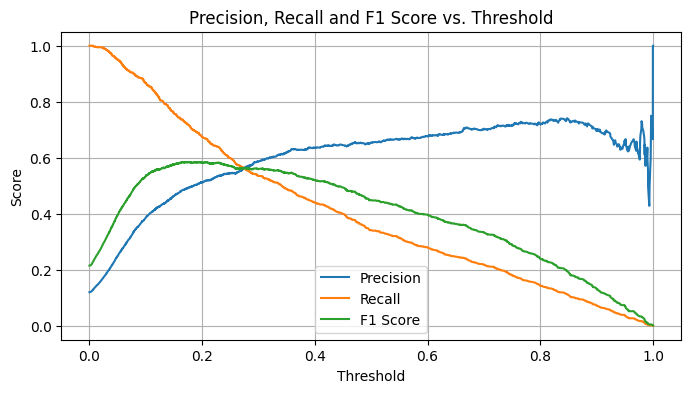

In [23]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Predict probabilities
probabilities = log_reg_pipeline.predict_proba(X_test_prepared)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probabilities)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.nanargmax(f1_scores)  # nanargmax ignores NaN values in the array
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print("Optimal Threshold:", optimal_threshold)
print("Optimal F1 Score:", optimal_f1)
print("Precision:", precision[optimal_idx])
print("Recall:", recall[optimal_idx])

# Optionally, plot precision-recall vs threshold chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 Score vs. Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.show()


Cross-validated ROC AUC scores for Decision Tree: [0.71178672 0.69395993 0.71435442 0.68967723 0.70362682]
Mean ROC AUC score for Decision Tree: 0.702681021123033
Optimal Threshold for Decision Tree: 1.0
Optimal F1 Score for Decision Tree: 0.48353631032927374
Precision for Decision Tree: 0.47602131438721135
Recall for Decision Tree: 0.4912923923006416


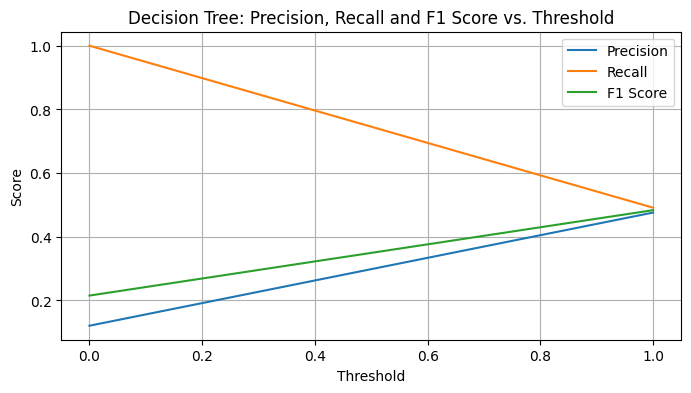

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Define the decision tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Evaluate the model using cross-validation for ROC AUC
tree_cv_scores = cross_val_score(decision_tree, X_train_prepared, y_train, cv=cv_strategy, scoring='roc_auc')
print("Cross-validated ROC AUC scores for Decision Tree:", tree_cv_scores)
print("Mean ROC AUC score for Decision Tree:", tree_cv_scores.mean())

# Fit the model to the training data
decision_tree.fit(X_train_prepared, y_train)

# Predict probabilities
dt_probabilities = decision_tree.predict_proba(X_test_prepared)[:, 1]

# Calculate precision, recall, and thresholds
dt_precision, dt_recall, dt_thresholds = precision_recall_curve(y_test, dt_probabilities)

# Calculate F1 scores for each threshold
dt_f1_scores = 2 * (dt_precision * dt_recall) / (dt_precision + dt_recall)
dt_optimal_idx = np.nanargmax(dt_f1_scores)  # Avoiding NaN values
dt_optimal_threshold = dt_thresholds[dt_optimal_idx]
dt_optimal_f1 = dt_f1_scores[dt_optimal_idx]

print("Optimal Threshold for Decision Tree:", dt_optimal_threshold)
print("Optimal F1 Score for Decision Tree:", dt_optimal_f1)
print("Precision for Decision Tree:", dt_precision[dt_optimal_idx])
print("Recall for Decision Tree:", dt_recall[dt_optimal_idx])

# Optionally, plot precision-recall vs threshold chart for Decision Tree
plt.figure(figsize=(8, 4))
plt.plot(dt_thresholds, dt_precision[:-1], label="Precision")
plt.plot(dt_thresholds, dt_recall[:-1], label="Recall")
plt.plot(dt_thresholds, dt_f1_scores[:-1], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Decision Tree: Precision, Recall and F1 Score vs. Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [25]:
# Extract feature names after one-hot encoding
feature_names = list(pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)) + [col for col in X.columns if col not in categorical_cols]

# Get the coefficients from the logistic regression model
log_reg_coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame for better visualization
log_reg_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg_coefficients
})

# Sort features by the absolute values of their coefficients for better interpretation
log_reg_feature_importance = log_reg_feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

print(log_reg_feature_importance.head(10))  # Display the top 10 features


             Feature  Coefficient
47          duration     1.081595
27   contact_unknown    -0.429839
42  poutcome_success     0.369145
25  contact_cellular     0.334243
48          campaign    -0.273094
34         month_jun     0.262870
35         month_mar     0.195566
22       housing_yes    -0.169417
21        housing_no     0.169417
33         month_jul    -0.167386


In [26]:
# Get feature importance from the decision tree model
tree_feature_importance = decision_tree.feature_importances_

# Create a DataFrame for better visualization
dt_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tree_feature_importance
})

# Sort features by importance
dt_feature_importance = dt_feature_importance.sort_values(by='Importance', ascending=False)

print(dt_feature_importance.head(10))  # Display the top 10 features


             Feature  Importance
47          duration    0.268723
45           balance    0.109701
42  poutcome_success    0.091093
44               age    0.089177
46               day    0.083872
49             pdays    0.046619
48          campaign    0.031183
21        housing_no    0.017261
50          previous    0.015686
35         month_mar    0.013505


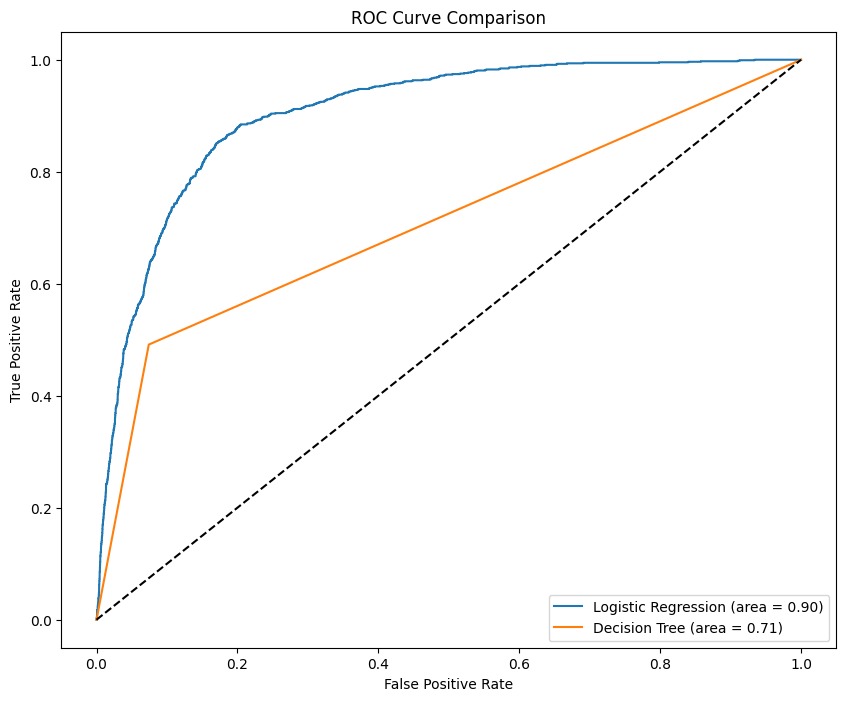

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve for Logistic Regression
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, probabilities)
logreg_auc = auc(logreg_fpr, logreg_tpr)

# Calculate ROC curve for Decision Tree
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probabilities)
dt_auc = auc(dt_fpr, dt_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (area = {logreg_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (area = {dt_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


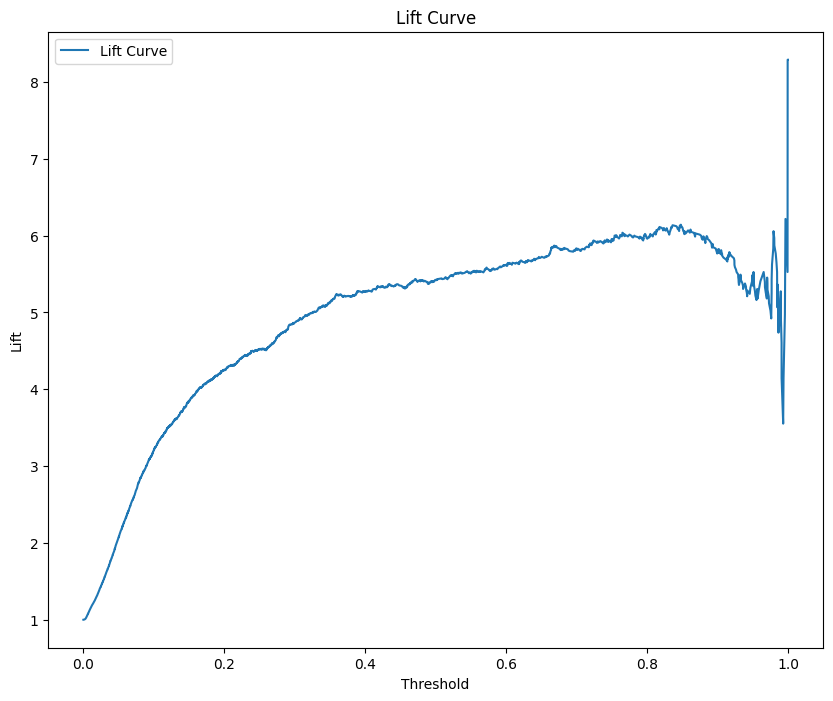

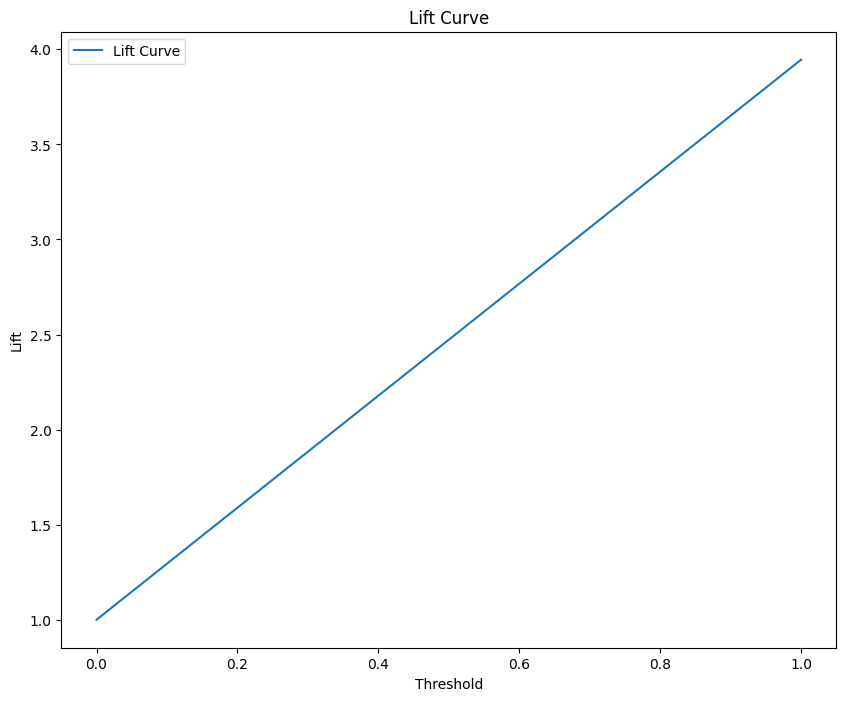

In [8]:
def plot_lift_curve(y_true, y_scores):
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    # Calculate the lift
    lift = precision / np.mean(y_true)

    # Plot the Lift Curve
    plt.figure(figsize=(10, 8))
    plt.plot(thresholds, lift[:-1], label='Lift Curve')
    plt.xlabel('Threshold')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend()
    plt.show()

# Plot lift curves
plot_lift_curve(y_test, probabilities)  # For Logistic Regression
plot_lift_curve(y_test, dt_probabilities)  # For Decision Tree


In [28]:
def calculate_profit(y_true, probabilities, threshold, cost_per_contact, profit_per_conversion):
    # Make predictions based on the threshold
    predictions = (probabilities >= threshold).astype(int)

    # Calculate the number of true positives (actual conversions)
    true_positives = (predictions == 1) & (y_true == 1)

    # Calculate costs and revenue
    total_contacts = predictions.sum()
    total_costs = total_contacts * cost_per_contact
    total_revenue = true_positives.sum() * profit_per_conversion

    # Calculate net profit
    net_profit = total_revenue - total_costs
    return net_profit, total_contacts, true_positives.sum()

# Parameters
cost_per_contact = 2
profit_per_conversion = 20

# Logistic Regression Cost-Benefit Analysis
logreg_net_profit, logreg_contacts, logreg_conversions = calculate_profit(
    y_test, probabilities, optimal_threshold, cost_per_contact, profit_per_conversion)

# Decision Tree Cost-Benefit Analysis
dt_net_profit, dt_contacts, dt_conversions = calculate_profit(
    y_test, dt_probabilities, dt_optimal_threshold, cost_per_contact, profit_per_conversion)

print("Logistic Regression Cost-Benefit Analysis:")
print("Net Profit: $", logreg_net_profit)
print("Total Contacts:", logreg_contacts)
print("Successful Conversions:", logreg_conversions)

print("\nDecision Tree Cost-Benefit Analysis:")
print("Net Profit: $", dt_net_profit)
print("Total Contacts:", dt_contacts)
print("Successful Conversions:", dt_conversions)


Logistic Regression Cost-Benefit Analysis:
Net Profit: $ 12598
Total Contacts: 1611
Successful Conversions: 791

Decision Tree Cost-Benefit Analysis:
Net Profit: $ 8468
Total Contacts: 1126
Successful Conversions: 536


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Use cross-validation to evaluate the model
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(random_forest, X_train_prepared, y_train, cv=cv_strategy, scoring='roc_auc')

# Fit the model on the training data
random_forest.fit(X_train_prepared, y_train)

print("Cross-validated ROC AUC scores for Random Forest:", rf_cv_scores)
print("Mean ROC AUC score for Random Forest:", rf_cv_scores.mean())


Cross-validated ROC AUC scores for Random Forest: [0.92978657 0.92611228 0.92722176 0.92887896 0.92804963]
Mean ROC AUC score for Random Forest: 0.9280098418692477


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Make predictions on the test set
rf_probabilities = random_forest.predict_proba(X_test_prepared)[:, 1]
rf_predictions = random_forest.predict(X_test_prepared)

# Calculate metrics
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_probabilities)

print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print("Accuracy:", rf_accuracy)
print("ROC AUC:", rf_roc_auc)


Precision: 0.6583941605839416
Recall: 0.41338221814848763
F1 Score: 0.5078828828828829
Accuracy: 0.9033506579674887
ROC AUC: 0.9249866176896393


In [31]:
# Assuming the same cost and profit settings as before
cost_per_contact = 2
profit_per_conversion = 20

# Using the previously defined function for profit calculation
rf_net_profit, rf_contacts, rf_conversions = calculate_profit(
    y_test, rf_probabilities, optimal_threshold, cost_per_contact, profit_per_conversion)

print("Random Forest Cost-Benefit Analysis:")
print("Net Profit: $", rf_net_profit)
print("Total Contacts:", rf_contacts)
print("Successful Conversions:", rf_conversions)


Random Forest Cost-Benefit Analysis:
Net Profit: $ 14530
Total Contacts: 2065
Successful Conversions: 933


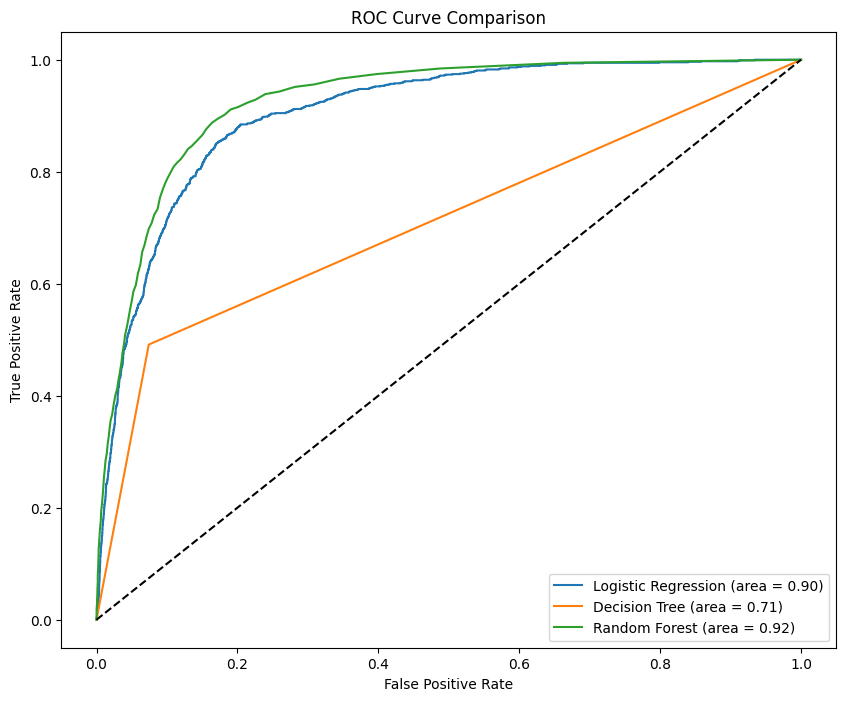

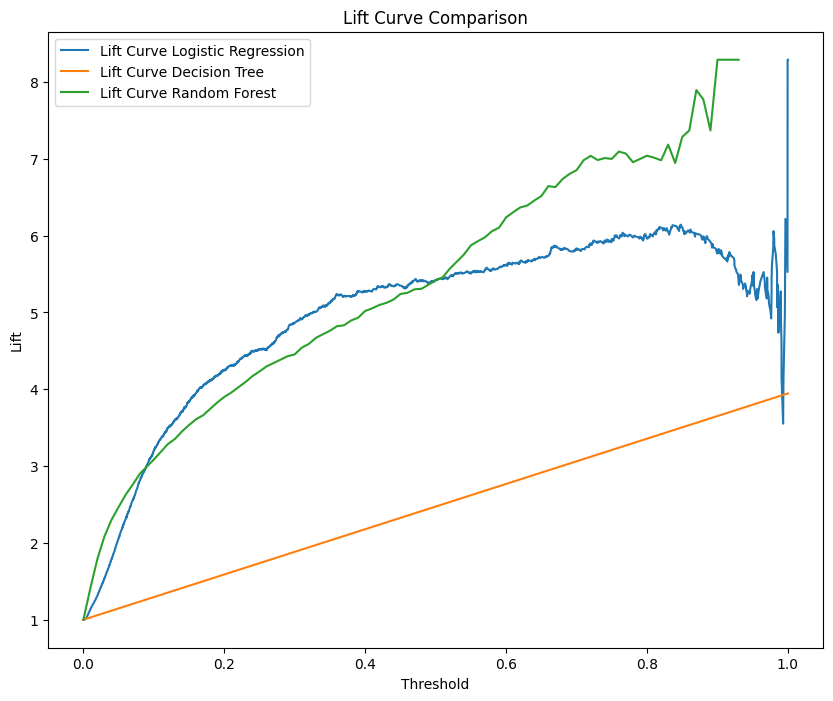

In [18]:
# Logistic Regression Probability Predictions
probabilities_logreg = log_reg_pipeline.predict_proba(X_test_prepared)[:, 1]

# Decision Tree Probability Predictions
dt_probabilities = decision_tree.predict_proba(X_test_prepared)[:, 1]

# Random Forest Probability Predictions
rf_probabilities = random_forest.predict_proba(X_test_prepared)[:, 1]


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

# Assuming you have the y_test and X_test_prepared
# Calculate probability predictions (add these lines in your code where you define the models)
probabilities_logreg = log_reg_pipeline.predict_proba(X_test_prepared)[:, 1]
dt_probabilities = decision_tree.predict_proba(X_test_prepared)[:, 1]
rf_probabilities = random_forest.predict_proba(X_test_prepared)[:, 1]

# Calculate ROC curve and ROC area for each model
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, probabilities_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probabilities)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (area = {roc_auc_logreg:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (area = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Lift Curve Function
def plot_lift_curve(y_true, y_scores, model_label):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    lift = precision / np.mean(y_true)
    plt.plot(thresholds, lift[:-1], label=f'Lift Curve {model_label}')

# Plotting Lift Curves
plt.figure(figsize=(10, 8))
plot_lift_curve(y_test, probabilities_logreg, 'Logistic Regression')
plot_lift_curve(y_test, dt_probabilities, 'Decision Tree')
plot_lift_curve(y_test, rf_probabilities, 'Random Forest')
plt.xlabel('Threshold')
plt.ylabel('Lift')
plt.title('Lift Curve Comparison')
plt.legend()
plt.show()


In [19]:
# Get feature importances from the random forest model
importances = random_forest.feature_importances_

# Assuming you have a list of feature names corresponding to the columns in X_train_prepared
feature_names = [f"feature_{i}" for i in range(X_train_prepared.shape[1])]  # Update with actual feature names if available

# Create a DataFrame to view the features and their importance scores
import pandas as pd
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame to see the most important features at the top
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances_sorted.head(10))  # Display the top 10 features


       Feature  Importance
47  feature_47    0.265257
45  feature_45    0.092704
44  feature_44    0.091939
46  feature_46    0.080623
42  feature_42    0.046546
48  feature_48    0.038773
49  feature_49    0.036737
50  feature_50    0.022411
21  feature_21    0.015241
28  feature_28    0.013144


In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Assuming you have identified all numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # StandardScaler for numeric features
        ('cat', OneHotEncoder(), categorical_features)  # OneHotEncoder for categorical features
    ])

# Create a pipeline with preprocessing and a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
# Fit the model pipeline on your training data
model_pipeline.fit(X_train, y_train)  # Ensure y_train is your target variable

# Extract feature names
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract feature importances from the RandomForestClassifier
importances = model_pipeline.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print(feature_importances.head(10))


                 Feature  Importance
1           num__balance    0.702046
0               num__age    0.250029
3   cat__job_blue-collar    0.004577
10      cat__job_student    0.004184
7       cat__job_retired    0.004173
15  cat__marital_married    0.003890
6    cat__job_management    0.003866
16   cat__marital_single    0.003805
11   cat__job_technician    0.003698
2        cat__job_admin.    0.003284
